# Data preparation
## Modality 4: Biometrics
This stage has the purpose of preparing the dataset for model training, it consists on:
- Exploratory Data Analysis
- Feature engineering
- Export CSV for unimodal supervised and unsupervised approaches
- Data preparation
    - Merge based on sample dataset key
    - Group setup for LOGO CV
    - Feature scaling

## Setup

### Libraries

In [1]:
import os
import numpy as np
import pandas as pd  
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics, tree, svm, preprocessing
from sklearn.datasets import make_blobs, make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
import seaborn as sns; sns.set()
from seaborn import heatmap

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Paths

In [2]:
input_path = '../../1_feature_extraction/output/'

output_path = '../output/'

# Global configuration path
glob_conf_path = '../../config/global_config_paper.py'

### Load local variables

In [3]:
exec(open(glob_conf_path).read())

## Exploratory Data Analysis

In [4]:
# Import dataset
m4_dataset = pd.read_csv(os.path.join(input_path, "m4_feature_extraction.csv"), skipinitialspace=True)

# See shape
m4_dataset.shape

(10301, 45)

In [5]:
# All columns except the unique ID column should be either integers or floats
m4_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10301 entries, 0 to 10300
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   house_ID                 10301 non-null  object 
 1   household_ID             10301 non-null  object 
 2   person_ID                10301 non-null  object 
 3   region                   10301 non-null  object 
 4   strata                   10301 non-null  object 
 5   locality_type            10301 non-null  object 
 6   locality_size            10301 non-null  object 
 7   age_months               10301 non-null  int64  
 8   age_years                10301 non-null  int64  
 9   sex                      10301 non-null  object 
 10  BMI_SD                   10301 non-null  float64
 11  label_cat                10301 non-null  object 
 12  label                    10301 non-null  int64  
 13  glucose_value            7374 non-null   float64
 14  hba1c_value           

In [6]:
# Percentages of null values
m4_dataset.isnull().mean()*100

house_ID                    0.000000
household_ID                0.000000
person_ID                   0.000000
region                      0.000000
strata                      0.000000
locality_type               0.000000
locality_size               0.000000
age_months                  0.000000
age_years                   0.000000
sex                         0.000000
BMI_SD                      0.000000
label_cat                   0.000000
label                       0.000000
glucose_value              28.414717
hba1c_value                29.977672
albumin_value              28.414717
hdl_chol_value             28.414717
ldl_chol_value             45.539268
total_chol_value           28.414717
creatinine_value           28.453548
insulin_value              28.414717
trig_value                 28.414717
weight1                    34.433550
weight2                    34.569459
height1                    34.433550
height2                    34.617998
waist1                     36.879915
w

As the hapatitis_B column is practically empty, it will be dropped completely. The weights and heigths of elderly people could be related to the way the data was imputed. 

In [7]:
# Drop hepatitis_B column
del m4_dataset["hepatitis_B"]

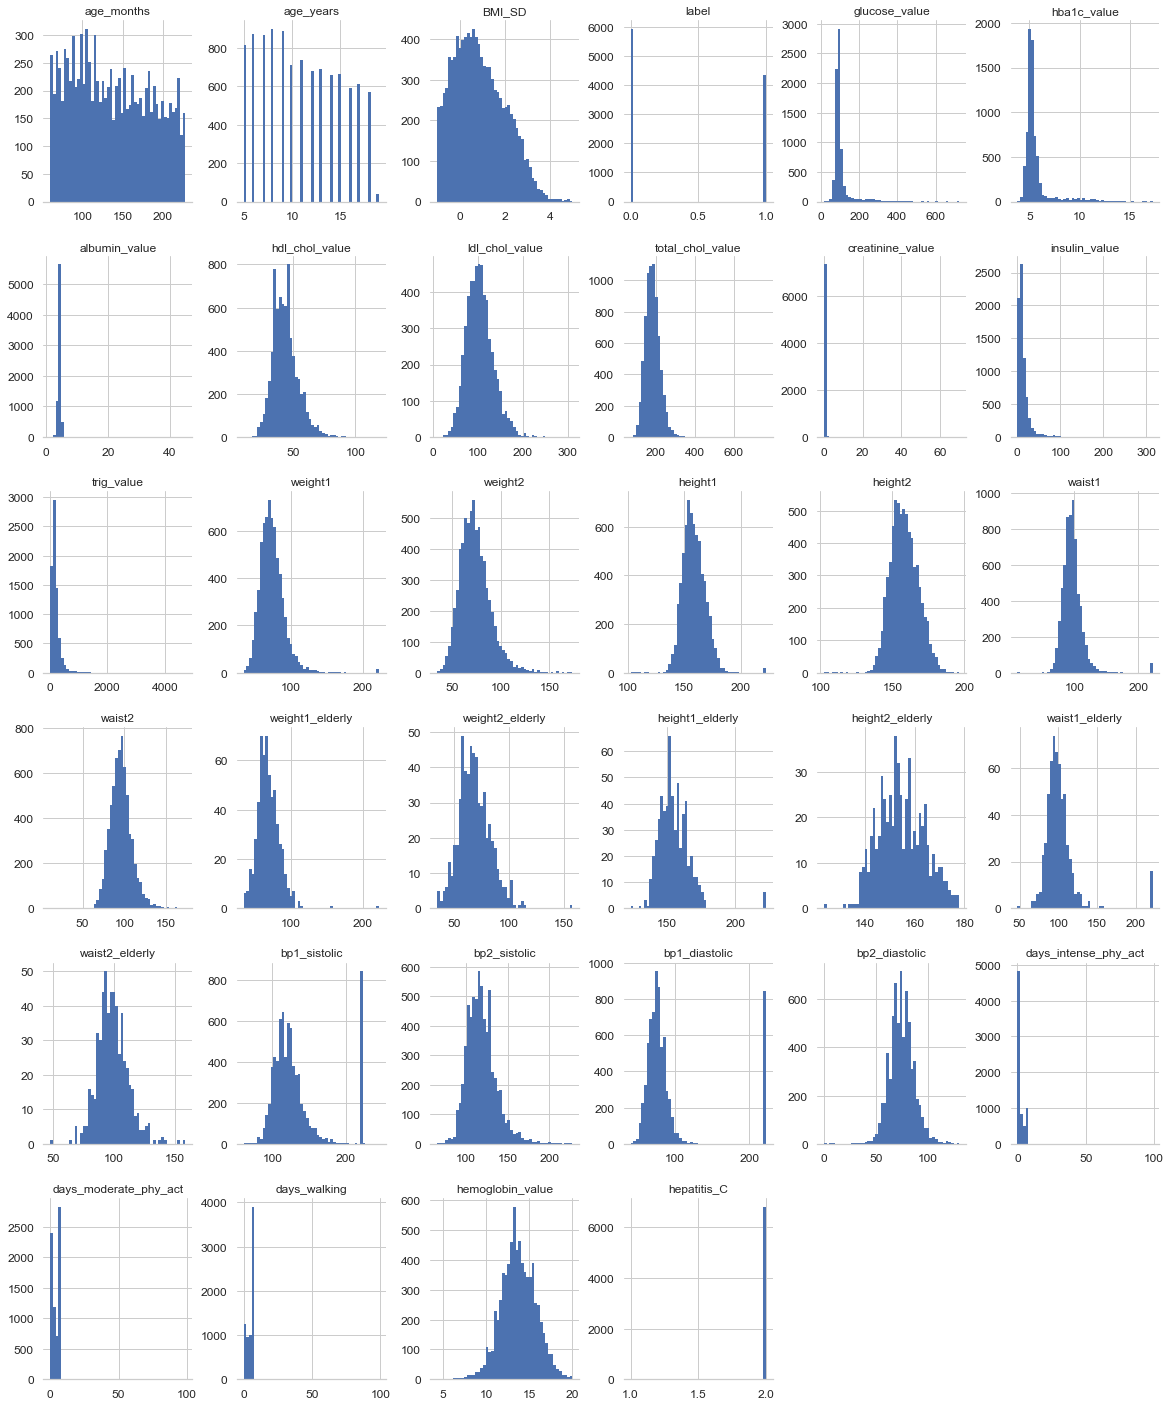

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
m4_dataset.hist(bins=50,figsize=(20,25))
plt.show()

hepatitis_C seems to be a boolean instead of an integer or float, so it will be removed.

In [9]:
# Drop hepatitis_C column
del m4_dataset["hepatitis_C"]

## Feature Engineering
Some transformations are required to provide more information, such as:
- BMI computation
- Average waist circunference
- Average systolic blood pressure
- Average dyastolic blood pressure

Since the weights, heights and waist circumference measurements are in different columns according to age, they need to be in just one column each. 

In [10]:
# Fill weight metrics in the NaN values places
m4_dataset["weight1"].fillna(m4_dataset["weight1_elderly"], inplace=True)
m4_dataset["weight2"].fillna(m4_dataset["weight2_elderly"], inplace=True)
m4_dataset["height1"].fillna(m4_dataset["height1_elderly"], inplace=True)
m4_dataset["height2"].fillna(m4_dataset["height2_elderly"], inplace=True)
m4_dataset["waist1"].fillna(m4_dataset["waist1_elderly"], inplace=True)
m4_dataset["waist2"].fillna(m4_dataset["waist2_elderly"], inplace=True)

In [11]:
m4_dataset.isnull().mean()*100

house_ID                    0.000000
household_ID                0.000000
person_ID                   0.000000
region                      0.000000
strata                      0.000000
locality_type               0.000000
locality_size               0.000000
age_months                  0.000000
age_years                   0.000000
sex                         0.000000
BMI_SD                      0.000000
label_cat                   0.000000
label                       0.000000
glucose_value              28.414717
hba1c_value                29.977672
albumin_value              28.414717
hdl_chol_value             28.414717
ldl_chol_value             45.539268
total_chol_value           28.414717
creatinine_value           28.453548
insulin_value              28.414717
trig_value                 28.414717
weight1                    28.735074
weight2                    28.880691
height1                    28.735074
height2                    28.977769
waist1                     31.181439
w

In [12]:
# Drop all the columns that refer to people over 60 years
del m4_dataset["weight1_elderly"]
del m4_dataset["weight2_elderly"]
del m4_dataset["height1_elderly"]
del m4_dataset["height2_elderly"]
del m4_dataset["waist1_elderly"]
del m4_dataset["waist2_elderly"]

In [13]:
m4_dataset.shape

(10301, 37)

Values 222.2, 222.22, and 222.222 were used to signal that the selected person was not available or did not want to get their measurements taken.
- Columns were graphed to quickly identify the existence of such values. 
- All values >= 222 were replaced by NaN values, since:
    - no value was higher than 222 for any of the columns, so those were only 'not registered' values 

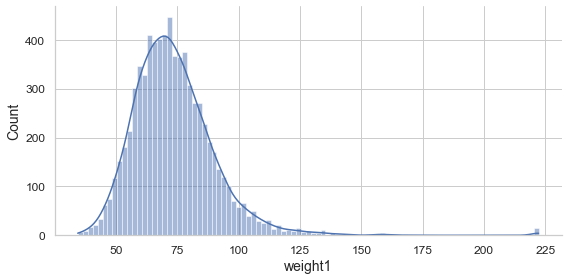

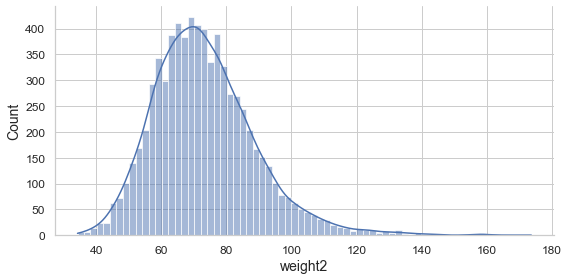

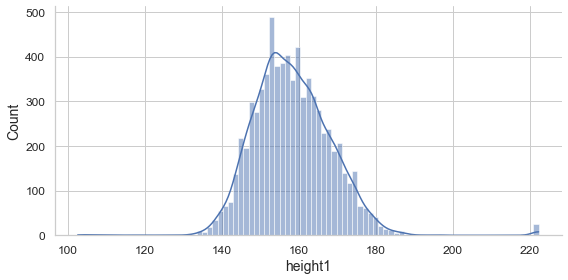

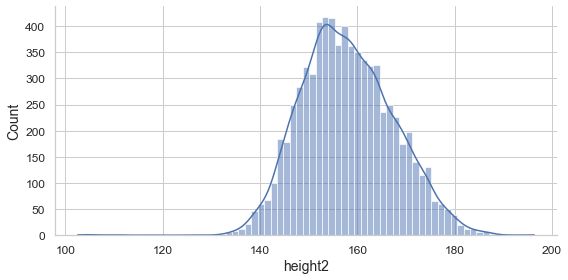

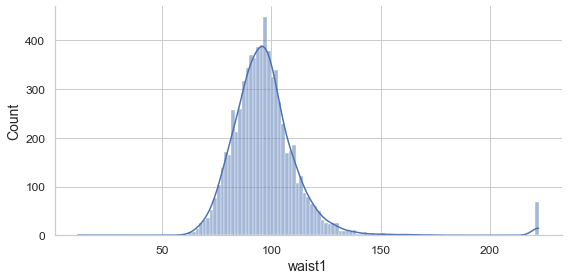

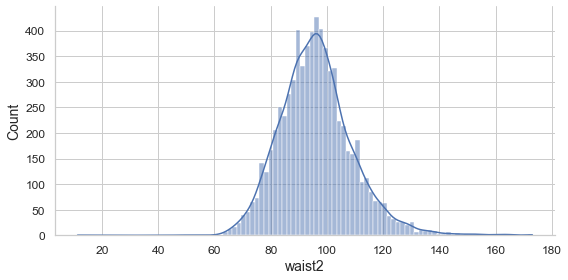

In [14]:
#Look for "not registered" values in each column (>=222, <223)
# 20 to 59 years
sns.displot(data=m4_dataset, x="weight1", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="weight2", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="height1", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="height2", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="waist1", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="waist2", kde=True, height=4, aspect=2)

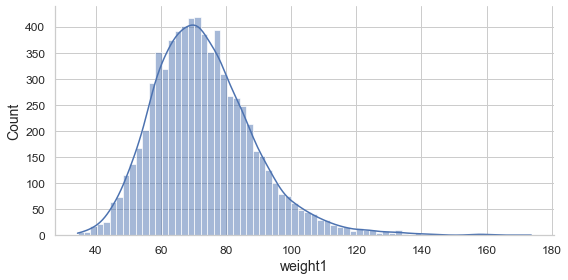

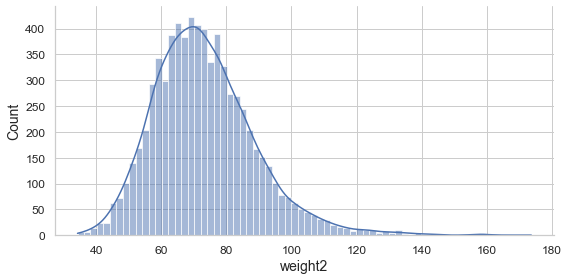

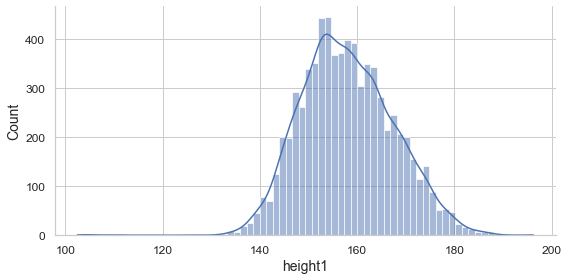

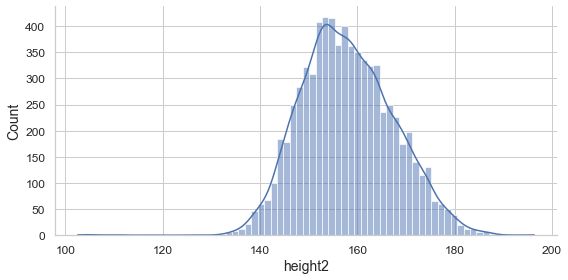

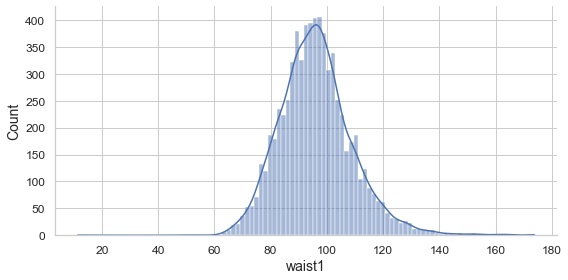

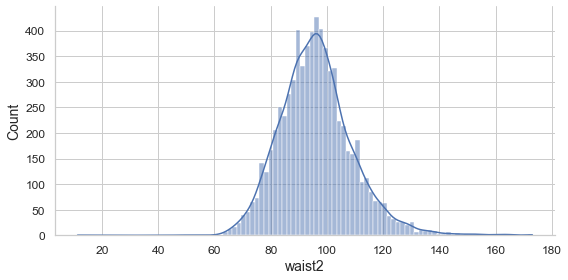

In [15]:
# Keep only values below 222
m4_dataset.replace({222.0:np.nan}, inplace=True)
m4_dataset.replace({222.2:np.nan}, inplace=True)
m4_dataset.replace({222.22:np.nan}, inplace=True)
m4_dataset.replace({222.222:np.nan}, inplace=True)
m4_dataset.replace({222.2222:np.nan}, inplace=True)

# Check again
sns.displot(data=m4_dataset, x="weight1", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="weight2", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="height1", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="height2", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="waist1", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="waist2", kde=True, height=4, aspect=2)

In [16]:
m4_dataset.isnull().mean()*100

house_ID                    0.000000
household_ID                0.000000
person_ID                   0.000000
region                      0.000000
strata                      0.000000
locality_type               0.000000
locality_size               0.000000
age_months                  0.398020
age_years                   0.000000
sex                         0.000000
BMI_SD                      0.000000
label_cat                   0.000000
label                       0.000000
glucose_value              28.453548
hba1c_value                29.977672
albumin_value              28.414717
hdl_chol_value             28.414717
ldl_chol_value             45.568391
total_chol_value           28.822444
creatinine_value           28.453548
insulin_value              28.414717
trig_value                 28.628289
weight1                    28.880691
weight2                    28.880691
height1                    28.977769
height2                    28.977769
waist1                     31.841569
w

For other columns the values 88 and 99 were used as does not respond and does not know. Hence they need to be replace with NaN values.

In [17]:
m4_dataset.loc[m4_dataset["days_intense_phy_act"] == 55, "days_intense_phy_act"] = np.nan
m4_dataset.loc[m4_dataset["days_intense_phy_act"] == 88, "days_intense_phy_act"] = np.nan
m4_dataset.loc[m4_dataset["days_intense_phy_act"] == 99, "days_intense_phy_act"] = np.nan

m4_dataset.loc[m4_dataset["days_moderate_phy_act"] == 88, "days_moderate_phy_act"] = np.nan
m4_dataset.loc[m4_dataset["days_moderate_phy_act"] == 99, "days_moderate_phy_act"] = np.nan

m4_dataset.loc[m4_dataset["days_walking"] == 88, "days_walking"] = np.nan
m4_dataset.loc[m4_dataset["days_walking"] == 99, "days_walking"] = np.nan

m4_dataset.loc[m4_dataset["daily_hours_sitted_down"] == "88:88", "daily_hours_sitted_down"] = np.nan
m4_dataset.loc[m4_dataset["daily_hours_sitted_down"] == "99:99", "daily_hours_sitted_down"] = np.nan

Lets verify the column in hours, and change the format to float. 

In [18]:
m4_dataset["daily_hours_sitted_down"].unique()

array(['04:00', '03:00', nan, '01:00', '00:10', '00:30', '10:00', '05:00',
       '12:00', '02:00', '08:00', '14:00', '06:00', '01:30', '13:00',
       '07:00', '00:40', '02:30', '16:00', '00:20', '03:30', '00:01',
       '00:15', '00:05', '04:30', '06:30', '00:04', '00:25', '09:00',
       '01:20', '02:20', '00:55', '02:15', '01:10', '00:45', '15:00',
       '10:30', '02:45', '08:25', '02:03', '00:08', '11:00', '01:40',
       '00:02', '00:35', '02:40', '00:03', '01:15', '02:55', '01:45',
       '02:50', '04:40', '00:50', '01:50', '09:30', '00:11', '11:30',
       '02:06', '00:07', '05:30', '03:09', '03:07', '09:09', '03:20',
       '08:30', '00:14', '03:50', '00:09', '07:20', '12:40', '01:09',
       '00:18'], dtype=object)

In [19]:
daily_hours_sitted_down_data = m4_dataset[["daily_hours_sitted_down", "person_ID"]]
daily_hours_sitted_down_data

,daily_hours_sitted_down,person_ID
0,04:00,1_4_1_8
1,03:00,3_2_1_5
2,NaN,4_1_1_4
3,NaN,4_3_1_5
4,03:00,4_5_1_5
...,...,...
10296,NaN,3938_17_1_3
10297,NaN,3938_17_1_4
10298,00:30,3938_19_1_3
10299,00:30,3938_19_1_5


In [20]:
daily_hours_sitted_down_data = daily_hours_sitted_down_data.dropna()

In [21]:
daily_hours_sitted_down_data["minutes_sitting"] = daily_hours_sitted_down_data["daily_hours_sitted_down"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

C:\Users\rosar\AppData\Local\Temp\ipykernel_2460\2816384359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_hours_sitted_down_data["minutes_sitting"] = daily_hours_sitted_down_data["daily_hours_sitted_down"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))


In [22]:
del daily_hours_sitted_down_data["daily_hours_sitted_down"]
daily_hours_sitted_down_data

,person_ID,minutes_sitting
0,1_4_1_8,240
1,3_2_1_5,180
4,4_5_1_5,180
5,4_5_1_6,180
6,6_4_1_3,60
...,...,...
10287,3937_16_1_4,120
10289,3937_21_1_3,180
10294,3938_10_1_3,420
10298,3938_19_1_3,30


In [23]:
m4_dataset.shape

(10301, 37)

In [24]:
# Delete old column in m4_dataset
del m4_dataset["daily_hours_sitted_down"]

# Concatenate newly calculated column
m4_dataset = m4_dataset.merge(daily_hours_sitted_down_data, left_on="person_ID", right_on="person_ID", how="left")

m4_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10301 entries, 0 to 10300
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   house_ID               10301 non-null  object 
 1   household_ID           10301 non-null  object 
 2   person_ID              10301 non-null  object 
 3   region                 10301 non-null  object 
 4   strata                 10301 non-null  object 
 5   locality_type          10301 non-null  object 
 6   locality_size          10301 non-null  object 
 7   age_months             10260 non-null  float64
 8   age_years              10301 non-null  float64
 9   sex                    10301 non-null  object 
 10  BMI_SD                 10301 non-null  float64
 11  label_cat              10301 non-null  object 
 12  label                  10301 non-null  float64
 13  glucose_value          7370 non-null   float64
 14  hba1c_value            7213 non-null   float64
 15  al

In [25]:
m4_dataset.shape

(10301, 37)

In [26]:
m4_dataset.isnull().mean()*100

house_ID                  0.000000
household_ID              0.000000
person_ID                 0.000000
region                    0.000000
strata                    0.000000
locality_type             0.000000
locality_size             0.000000
age_months                0.398020
age_years                 0.000000
sex                       0.000000
BMI_SD                    0.000000
label_cat                 0.000000
label                     0.000000
glucose_value            28.453548
hba1c_value              29.977672
albumin_value            28.414717
hdl_chol_value           28.414717
ldl_chol_value           45.568391
total_chol_value         28.822444
creatinine_value         28.453548
insulin_value            28.414717
trig_value               28.628289
weight1                  28.880691
weight2                  28.880691
height1                  28.977769
height2                  28.977769
waist1                   31.841569
waist2                   31.841569
bp1_sistolic        

See distribution of Blood pressure

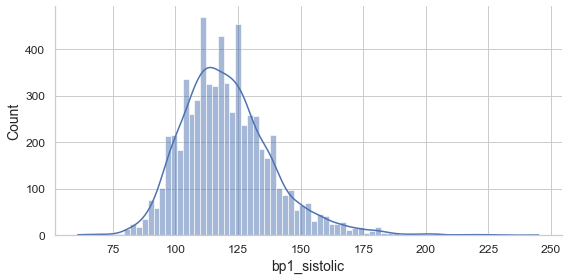

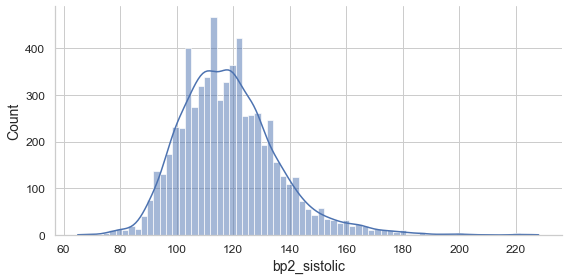

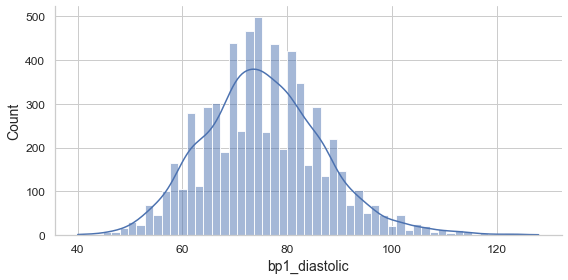

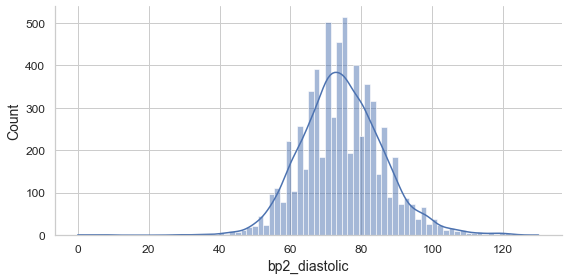

In [27]:
# Check blood pressure distribution
sns.displot(data=m4_dataset, x="bp1_sistolic", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="bp2_sistolic", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="bp1_diastolic", kde=True, height=4, aspect=2)
sns.displot(data=m4_dataset, x="bp2_diastolic", kde=True, height=4, aspect=2)

There may be values 222.2, 222.22, and 222.222. Those were used to signal that the selected person was not available or did not want to get their measurements taken. Lets verify there are none in the systolic blood pressure dimensions. 

In [28]:
m4_dataset.loc[m4_dataset["bp1_sistolic"] >= 222, "bp1_sistolic"]

3497    223.0
3498    223.0
4829    245.0
6645    231.0
7102    227.0
Name: bp1_sistolic, dtype: float64

In [29]:
m4_dataset.loc[m4_dataset["bp2_sistolic"] >= 222, "bp1_sistolic"]

4829    245.0
7102    227.0
9806    215.0
Name: bp1_sistolic, dtype: float64

Since none of them seem to be NaN values, they will remain the same.

Now lets calculate the random_adult BMI and the averages of waist and blood pressures (systolic and dyastolic).

In [30]:
#Create a new column with the averages of weight and height
m4_dataset["av_weight"] = m4_dataset[["weight1", "weight2"]].mean(axis=1)
m4_dataset["av_height"] = m4_dataset[["height1", "height2"]].mean(axis=1)

#Calculate BMI
m4_dataset["BMI_random_adult"] = (m4_dataset["av_weight"]/(m4_dataset["av_height"]*0.01)**2)

#Create a new column with the averages of waist
m4_dataset["av_waist"] = m4_dataset[["waist1", "waist2"]].mean(axis=1)

#Create a new column with the averages of systolic blood pressure
m4_dataset["av_systolic_bp"] = m4_dataset[["bp1_sistolic", "bp2_sistolic"]].mean(axis=1)

#Create a new column with the averages of dyastolic blood pressure
m4_dataset["av_dyastolic_bp"] = m4_dataset[["bp1_diastolic", "bp2_diastolic"]].mean(axis=1)

# Then we can delete all the unnecesary columns
del m4_dataset["weight1"]
del m4_dataset["weight2"]
del m4_dataset["height1"]
del m4_dataset["height2"]
del m4_dataset["av_weight"]
del m4_dataset["av_height"]
del m4_dataset["waist1"]
del m4_dataset["waist2"]
del m4_dataset["bp1_sistolic"]
del m4_dataset["bp2_sistolic"]
del m4_dataset["bp1_diastolic"]
del m4_dataset["bp2_diastolic"]

# Check general info
m4_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10301 entries, 0 to 10300
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   house_ID               10301 non-null  object 
 1   household_ID           10301 non-null  object 
 2   person_ID              10301 non-null  object 
 3   region                 10301 non-null  object 
 4   strata                 10301 non-null  object 
 5   locality_type          10301 non-null  object 
 6   locality_size          10301 non-null  object 
 7   age_months             10260 non-null  float64
 8   age_years              10301 non-null  float64
 9   sex                    10301 non-null  object 
 10  BMI_SD                 10301 non-null  float64
 11  label_cat              10301 non-null  object 
 12  label                  10301 non-null  float64
 13  glucose_value          7370 non-null   float64
 14  hba1c_value            7213 non-null   float64
 15  al

### See new distributions

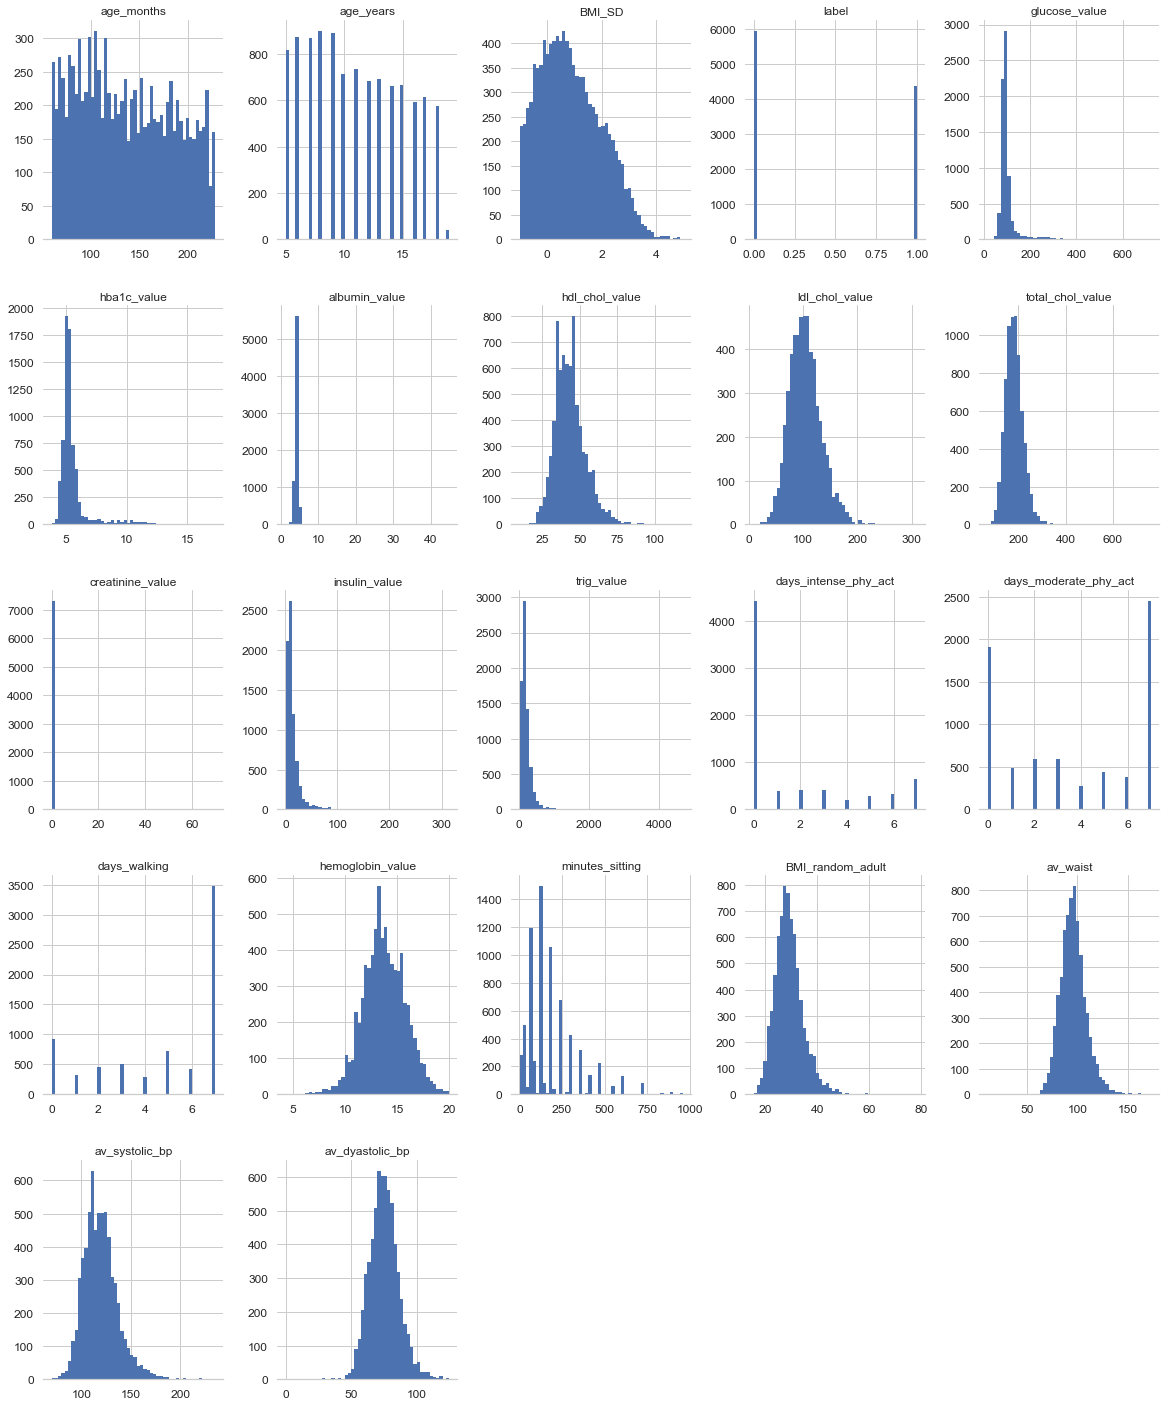

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
m4_dataset.hist(bins=50,figsize=(20,25))
plt.show()

### Check correlations

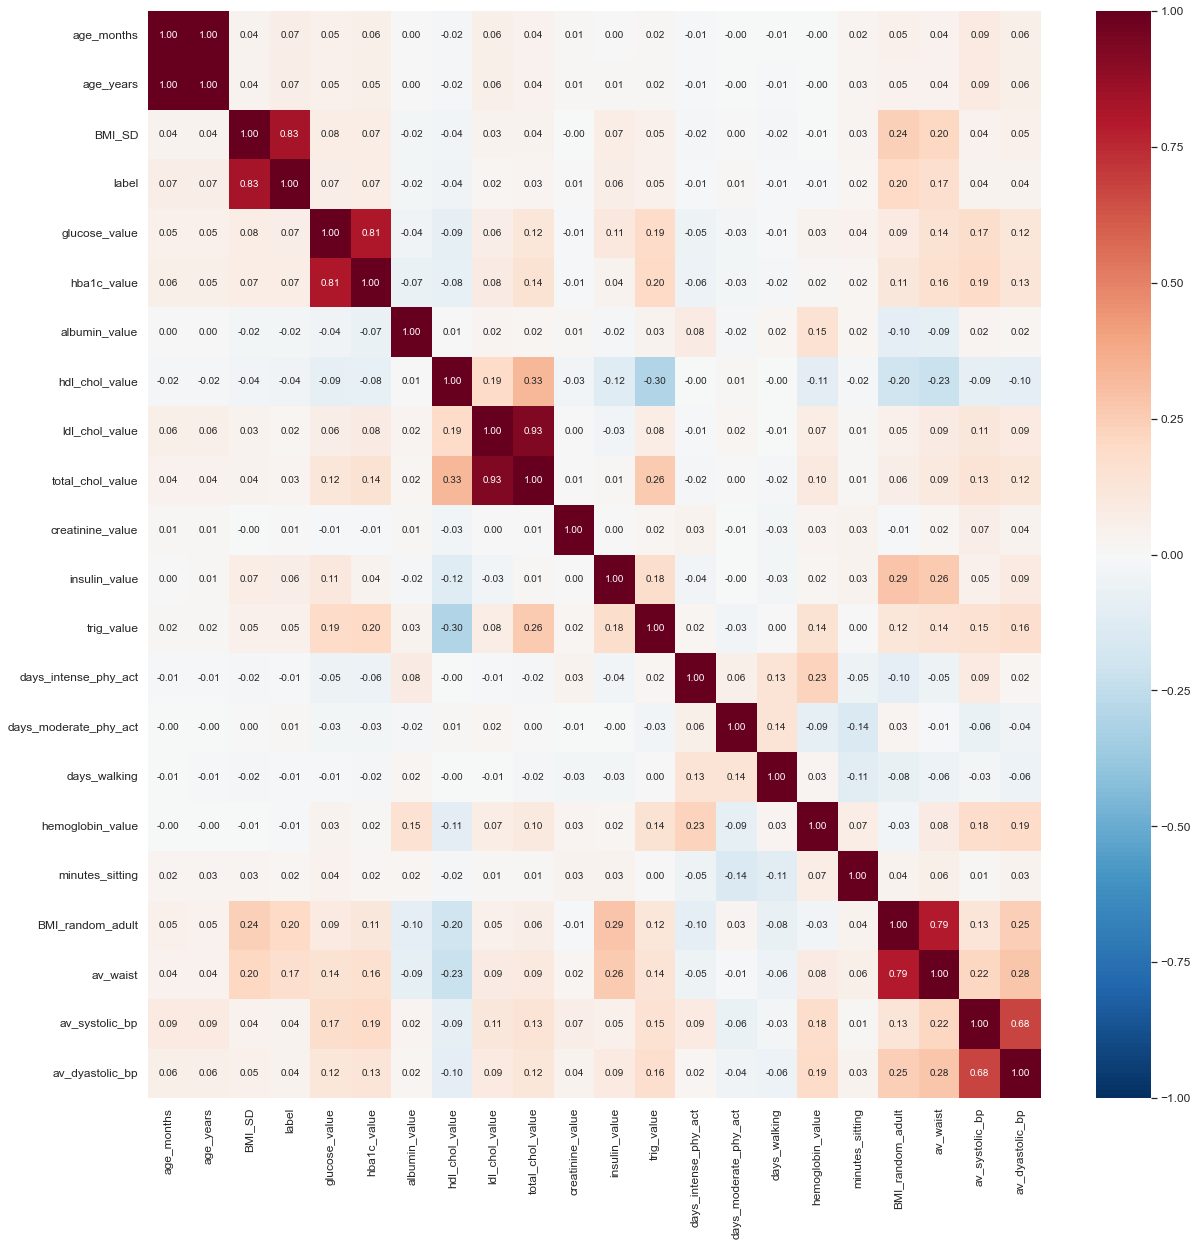

In [32]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize=(20,20))
ax = heatmap(m4_dataset.corr(), fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1)

In [33]:
# Remove features causing multi-collinearity
del m4_dataset["total_chol_value"]

In [34]:
m4_dataset.shape

(10301, 30)

## Export CSV for unimodal supervised and unsupervised approaches

In [35]:
# Create copy
m4_unimodal = m4_dataset.copy()

# See info
m4_unimodal.columns.tolist()

['house_ID',
 'household_ID',
 'person_ID',
 'region',
 'strata',
 'locality_type',
 'locality_size',
 'age_months',
 'age_years',
 'sex',
 'BMI_SD',
 'label_cat',
 'label',
 'glucose_value',
 'hba1c_value',
 'albumin_value',
 'hdl_chol_value',
 'ldl_chol_value',
 'creatinine_value',
 'insulin_value',
 'trig_value',
 'days_intense_phy_act',
 'days_moderate_phy_act',
 'days_walking',
 'hemoglobin_value',
 'minutes_sitting',
 'BMI_random_adult',
 'av_waist',
 'av_systolic_bp',
 'av_dyastolic_bp']

In [36]:
# Export unimodal CSV
m4_unimodal.to_csv(os.path.join(output_path,'m4_unimodal.csv'), index=None, header=True)

## Data preparation

### Merge based on sample dataset key
This was already done.

### Check for missing values

In [37]:
# Drop all NaN values
m4_dataset = m4_dataset.dropna()
m4_dataset.shape

(4419, 30)

In [38]:
# Verify no NaNs
m4_dataset.isnull().mean()*100

house_ID                 0.0
household_ID             0.0
person_ID                0.0
region                   0.0
strata                   0.0
locality_type            0.0
locality_size            0.0
age_months               0.0
age_years                0.0
sex                      0.0
BMI_SD                   0.0
label_cat                0.0
label                    0.0
glucose_value            0.0
hba1c_value              0.0
albumin_value            0.0
hdl_chol_value           0.0
ldl_chol_value           0.0
creatinine_value         0.0
insulin_value            0.0
trig_value               0.0
days_intense_phy_act     0.0
days_moderate_phy_act    0.0
days_walking             0.0
hemoglobin_value         0.0
minutes_sitting          0.0
BMI_random_adult         0.0
av_waist                 0.0
av_systolic_bp           0.0
av_dyastolic_bp          0.0
dtype: float64

### Check label distribution

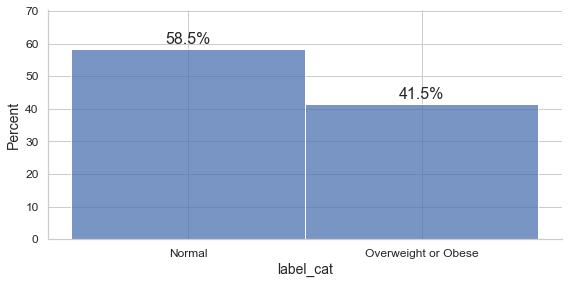

In [39]:
binary_SD_dist = sns.displot(data=m4_dataset, x="label_cat", 
                       height=4, aspect=2, stat='percent')
show_label_percent(binary_SD_dist)
plt.show()

## Group setup for LOGO CV

### Create random groups for the Leave-One-Group-Out Cross-Validation

In [40]:
# Reset index
m4_dataset.reset_index(drop=True, inplace=True)

# Create fair random groups from 1 to 5 as a numpy array and convert it into DataFrame
random_groups = np.random.uniform(1,6,size=len(m4_dataset))
random_groups = pd.DataFrame(random_groups.astype(int))

# Assign group dataframe into column "group"
m4_dataset["group"] = random_groups
m4_dataset

,house_ID,household_ID,person_ID,region,strata,locality_type,locality_size,age_months,age_years,sex,...,days_intense_phy_act,days_moderate_phy_act,days_walking,hemoglobin_value,minutes_sitting,BMI_random_adult,av_waist,av_systolic_bp,av_dyastolic_bp,group
0,1_4,1_4_1,1_4_1_8,Centre,3rd_strata,urban,">100,000",122.0,10.0,female,...,0.0,0.0,3.0,12.9,240.0,33.806611,101.50,81.0,47.5,5
1,3_2,3_2_1,3_2_1_5,Centre,2nd_strata,urban,">100,000",149.0,12.0,female,...,0.0,0.0,7.0,15.0,180.0,35.447292,123.85,114.5,70.0,3
2,4_5,4_5_1,4_5_1_5,Centre,2nd_strata,urban,">100,000",169.0,14.0,male,...,0.0,6.0,7.0,14.2,180.0,21.715140,86.80,106.0,96.0,2
3,4_5,4_5_1,4_5_1_6,Centre,2nd_strata,urban,">100,000",114.0,9.0,female,...,0.0,6.0,7.0,14.2,180.0,21.715140,86.80,106.0,96.0,2
4,6_4,6_4_1,6_4_1_3,Centre,2nd_strata,urban,">100,000",78.0,6.0,female,...,1.0,7.0,4.0,12.6,60.0,31.460128,99.80,123.5,71.5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,3935_15,3935_15_1,3935_15_1_3,Centre,2nd_strata,rural,"<2,500",206.0,17.0,male,...,0.0,0.0,7.0,13.0,120.0,26.479739,87.00,141.0,83.5,2
4415,3937_16,3937_16_1,3937_16_1_3,Centre,2nd_strata,rural,"<2,500",177.0,14.0,female,...,0.0,7.0,5.0,13.5,120.0,28.886057,96.00,112.5,71.5,3
4416,3937_16,3937_16_1,3937_16_1_4,Centre,2nd_strata,rural,"<2,500",116.0,9.0,female,...,0.0,7.0,5.0,13.5,120.0,28.886057,96.00,112.5,71.5,2
4417,3938_19,3938_19_1,3938_19_1_3,Centre,2nd_strata,rural,"<2,500",170.0,14.0,male,...,1.0,7.0,7.0,15.0,30.0,20.770953,77.10,128.0,60.0,3


In [41]:
# Verify size, NaN and Dtype of everything
m4_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4419 entries, 0 to 4418
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   house_ID               4419 non-null   object 
 1   household_ID           4419 non-null   object 
 2   person_ID              4419 non-null   object 
 3   region                 4419 non-null   object 
 4   strata                 4419 non-null   object 
 5   locality_type          4419 non-null   object 
 6   locality_size          4419 non-null   object 
 7   age_months             4419 non-null   float64
 8   age_years              4419 non-null   float64
 9   sex                    4419 non-null   object 
 10  BMI_SD                 4419 non-null   float64
 11  label_cat              4419 non-null   object 
 12  label                  4419 non-null   float64
 13  glucose_value          4419 non-null   float64
 14  hba1c_value            4419 non-null   float64
 15  albu

### Check group representation

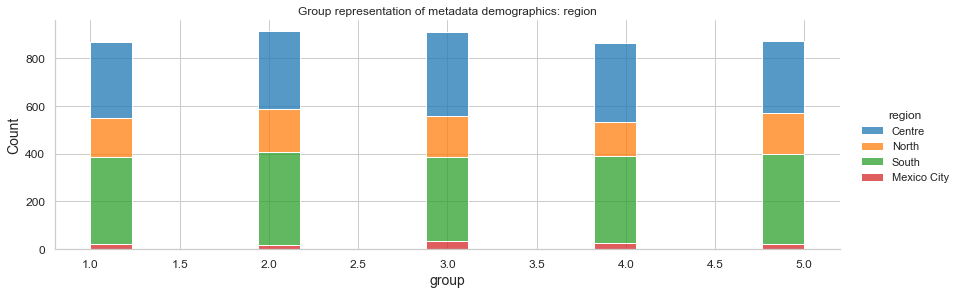

In [42]:
# Plot distributions to see representation of demographics in the groups
group_region = sns.displot(data=m4_dataset, x="group", hue="region", multiple="stack", palette="tab10",
                       height=4, aspect=3).set(title="""Group representation of metadata demographics: region""")
plt.show(group_region)

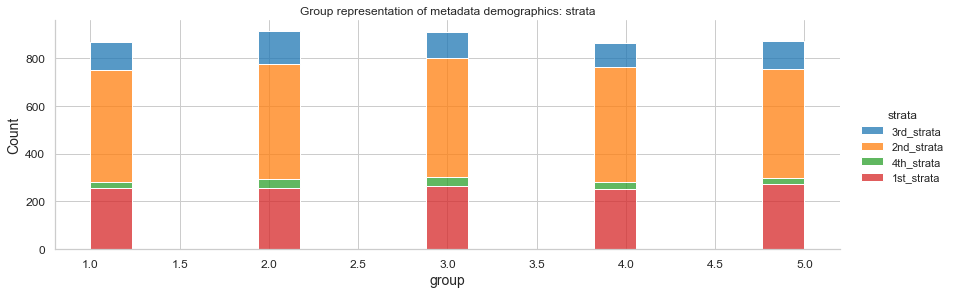

In [43]:
group_strata = sns.displot(data=m4_dataset, x="group", hue="strata", multiple="stack", palette="tab10",
                       height=4, aspect=3).set(title="""Group representation of metadata demographics: strata""")

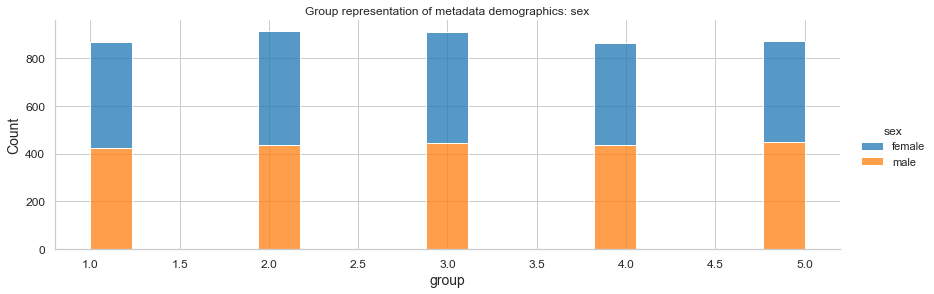

In [44]:
group_sex = sns.displot(data=m4_dataset, x="group", hue="sex", multiple="stack", palette="tab10",
                       height=4, aspect=3).set(title="""Group representation of metadata demographics: sex""")
plt.show(group_sex)

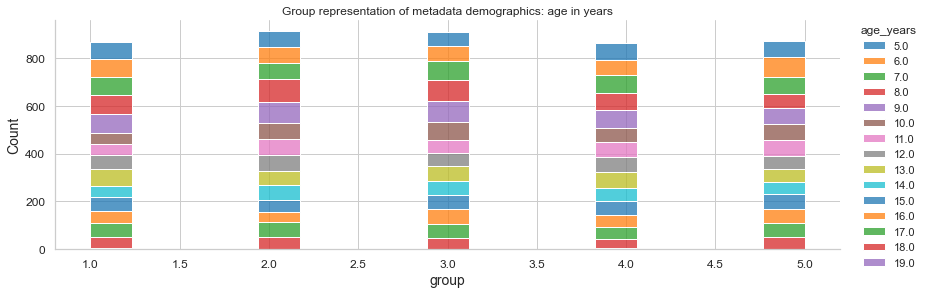

In [45]:
group_age_years = sns.displot(data=m4_dataset, x="group", hue="age_years", multiple="stack", palette="tab10",
                       height=4, aspect=3).set(title="""Group representation of metadata demographics: age in years""")

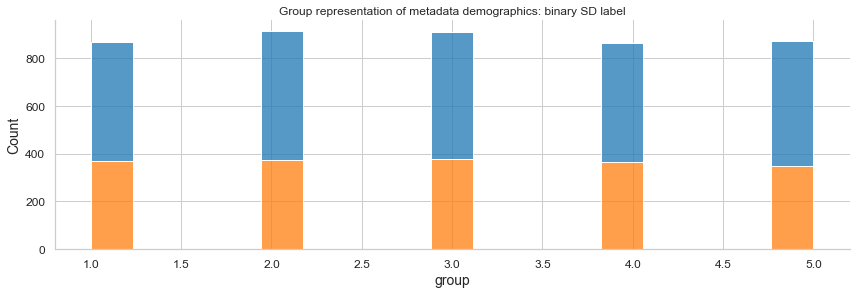

In [46]:
group_label_cat = sns.displot(data=m4_dataset, x="group", hue="label_cat", multiple="stack", palette="tab10",
                       height=4, aspect=3, legend=False).set(title="""Group representation of metadata demographics: binary SD label""")
plt.show(group_label_cat)

### Remove metadata

In [47]:
# Remove unnecesary metadata keeping only the label_cat
m4_dataset = m4_dataset.drop(columns=["house_ID", "household_ID", "person_ID",
                                      "region","strata","locality_type","locality_size",
                                      "sex","age_months","age_years","BMI_SD", "label_cat"])
m4_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4419 entries, 0 to 4418
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label                  4419 non-null   float64
 1   glucose_value          4419 non-null   float64
 2   hba1c_value            4419 non-null   float64
 3   albumin_value          4419 non-null   float64
 4   hdl_chol_value         4419 non-null   float64
 5   ldl_chol_value         4419 non-null   float64
 6   creatinine_value       4419 non-null   float64
 7   insulin_value          4419 non-null   float64
 8   trig_value             4419 non-null   float64
 9   days_intense_phy_act   4419 non-null   float64
 10  days_moderate_phy_act  4419 non-null   float64
 11  days_walking           4419 non-null   float64
 12  hemoglobin_value       4419 non-null   float64
 13  minutes_sitting        4419 non-null   float64
 14  BMI_random_adult       4419 non-null   float64
 15  av_w

## Feature scaling

In [48]:
# Separate metadata
metadata_df = m4_dataset[["label","group"]]

# Standardize values
X = m4_dataset.drop(columns=["label","group"])                    # Get features from training set
scaler = preprocessing.MinMaxScaler()                                     # m4 Standard scaler
X_norm = scaler.fit_transform(X)                                          # Fit and transform features
X_norm_df = pd.DataFrame(data=X_norm, columns=X.columns.to_list())      # Create a dataframe from normalized features

# Concatenate scaled dataframe and metadata
train_m4_norm_df = pd.concat([X_norm_df,metadata_df], axis=1)
train_m4_norm_df

,glucose_value,hba1c_value,albumin_value,hdl_chol_value,ldl_chol_value,creatinine_value,insulin_value,trig_value,days_intense_phy_act,days_moderate_phy_act,days_walking,hemoglobin_value,minutes_sitting,BMI_random_adult,av_waist,av_systolic_bp,av_dyastolic_bp,label,group
0,0.092044,0.059259,0.059952,0.448598,0.245095,0.006153,0.020946,0.277143,0.000000,0.000000,0.428571,0.547771,0.249218,0.365607,0.370712,0.058442,0.380,0.0,5
1,0.092044,0.111111,0.064748,0.280374,0.294978,0.008299,0.092813,0.480000,0.000000,0.000000,1.000000,0.681529,0.186653,0.398685,0.567282,0.275974,0.560,0.0,3
2,0.148206,0.148148,0.069544,0.149533,0.328234,0.008585,0.012640,0.542857,0.000000,0.857143,1.000000,0.630573,0.186653,0.121826,0.241425,0.220779,0.768,1.0,2
3,0.148206,0.148148,0.069544,0.149533,0.328234,0.008585,0.012640,0.542857,0.000000,0.857143,1.000000,0.630573,0.186653,0.121826,0.241425,0.220779,0.768,0.0,2
4,0.104524,0.111111,0.062350,0.224299,0.191886,0.008585,0.098230,0.231429,0.142857,1.000000,0.571429,0.528662,0.061522,0.318299,0.355761,0.334416,0.572,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,0.141966,0.088889,0.076739,0.364486,0.308281,0.007154,0.091730,0.525714,0.000000,0.000000,1.000000,0.554140,0.124088,0.217887,0.243184,0.448052,0.668,0.0,2
4415,0.082683,0.081481,0.069544,0.280374,0.225141,0.006009,0.083785,0.565714,0.000000,1.000000,0.714286,0.585987,0.124088,0.266402,0.322339,0.262987,0.572,0.0,3
4416,0.082683,0.081481,0.069544,0.280374,0.225141,0.006009,0.083785,0.565714,0.000000,1.000000,0.714286,0.585987,0.124088,0.266402,0.322339,0.262987,0.572,0.0,2
4417,0.115445,0.059259,0.067146,0.719626,0.138676,0.007726,0.050199,0.585714,0.142857,1.000000,1.000000,0.681529,0.030240,0.102790,0.156113,0.363636,0.480,1.0,3


In [49]:
train_m4_norm_df.shape

(4419, 19)

## Export datasets

In [50]:
# Export standardized dataset
train_m4_norm_df.to_csv(os.path.join(output_path,'train_m4_norm_df.csv'), index=None, header=True)